<a href="https://colab.research.google.com/github/facundograpsas/machine-learning/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Top 4% with ensemble modeling

### Tools

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style="white", context="notebook", palette="deep")


## Load and check data

### Load data

In [ ]:
train = pd.read_csv("drive/My Drive/Colab Datasets/train.csv")
test = pd.read_csv("drive/My Drive/Colab Datasets/test.csv")
IDtest = test["PassengerId"]

### Outlier detection

In [ ]:
def detect_outliers(df,n,features):
  """
  Takes a dataframe df of features and returns a list of the indices corresponding to the observations containing more than n outliers according to the Tukey method.
  """

  outlier_indices = []

  for col in features:
    Q1 = np.percentile(df[col].dropna(), 25)
    Q3 = np.percentile(df[col].dropna(), 75)
    IQR = Q3-Q1

    outlier_step = 1.5*IQR

    outlier_list_col = df[(df[col]<Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

    outlier_indices.extend(outlier_list_col)

  outlier_indices = Counter(outlier_indices)
  multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

  return multiple_outliers


In [ ]:
Outliers_to_drop = detect_outliers(train,2,["SibSp", "Fare", "Parch", "Age"])

In [ ]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [ ]:
# Drop outliers

train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### Joining train and test set 

In [ ]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion

train_len = len(train)
dataset = pd.concat(objs=[train,test], axis = 0).reset_index(drop=True)

### Check for null and missing values

In [ ]:
# Fill empty and Nans values with NaN
datatset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [ ]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  880 non-null    int64  
 1   Survived     880 non-null    int64  
 2   Pclass       880 non-null    int64  
 3   Name         880 non-null    object 
 4   Sex          880 non-null    object 
 5   Age          710 non-null    float64
 6   SibSp        880 non-null    int64  
 7   Parch        880 non-null    int64  
 8   Ticket       880 non-null    object 
 9   Fare         880 non-null    float64
 10  Cabin        200 non-null    object 
 11  Embarked     878 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.6+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,880.000000,880.000000,880.000000,710.000000,880.000000,880.000000,880.000000
mean,446.373864,0.386364,2.309091,29.674887,0.454545,0.362500,31.076249
std,256.564211,0.487192,0.834364,14.479217,0.871872,0.791998,48.004681
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,225.750000,0.000000,2.000000,20.125000,0.000000,0.000000,7.895800
50%,447.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.427100
75%,667.250000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## Feature analysis

### Numerical values

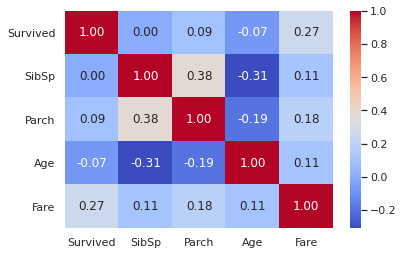

In [ ]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived
g = sns.heatmap(train[["Survived", "SibSp", "Parch", "Age", "Fare"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")

Only Fare feature seems to have a significative correlation with the survival probability.

It doesn't mean that the other features are not usefull. Subpopulation in hese features can be correlated with the survival. To determine this, we need to explore in detail these features

**SibSp**

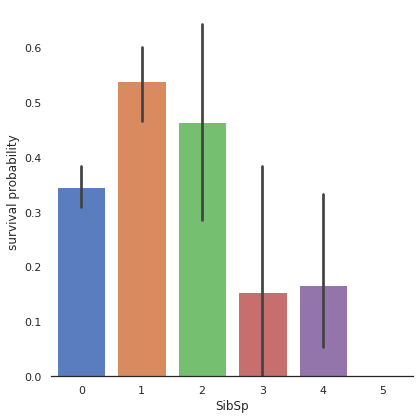

In [ ]:
g = sns.catplot(x="SibSp", y="Survived", data=train, kind="bar", height=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It seems that passangers having a lot of siblings/spouses have less chance to survive

Single passengers (0 SibSp) or with two other persons (SibSP 1 or 2) have mor chance to survive

This oservation is quite interesting, we can consider a new feature describing these categories


**Parch**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3692: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


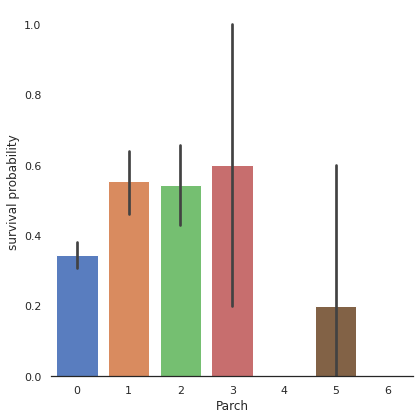

In [ ]:
g = sns.catplot(x="Parch", y="Survived", data=train, kind="bar", size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Small families have more chance to survive, more than single (Parch 0), medium(Parch 3,4) and large families (Parch 5,6)
There is an important standard deviation in the survival of passengers with 3 parents/children

**Age**


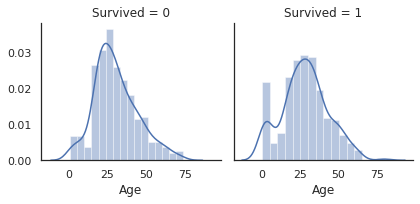

In [ ]:
g = sns.FacetGrid(train, col="Survived")
g = g.map(sns.distplot, "Age")

Age distribution seems to be a tailed distribution, maybe a gaussian distribution.

We notice that age distributions are not the same in the survived and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived.
We also see that passengers between 60-80 have less survived.

So, even if "Age" is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive.

It seems that very young passengers have more chance to survive.

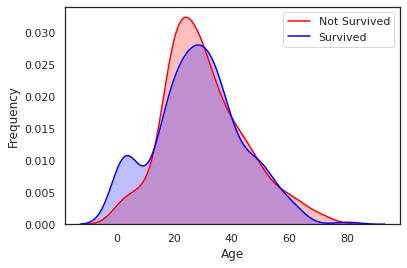

In [ ]:
g = sns.kdeplot(train["Age"][(train["Survived"]==0) & (train["Age"].notnull())], color="Red", shade=True)
g = sns.kdeplot(train["Age"][(train["Survived"]==1) & (train["Age"].notnull())], ax =g,color="Blue", shade=True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

When we superimpose the two densities, we clearly see a peak corresponding (between 0 and 5) to babies and very young childrens.

**Fare**

In [ ]:
dataset["Fare"].isnull().sum()

1

In [ ]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

Since we have one missing value, i decided to fill it with the median value which will not have an important effect on the prediction.

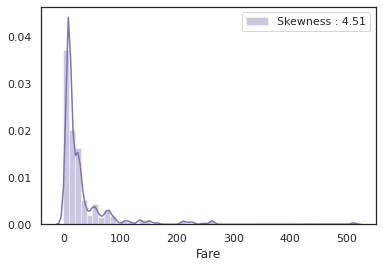

In [ ]:
# Explore Fare distribution
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend()

As we can see, Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled.

In this case, it is better to transform it with the log cuntion to reduce this skew.

In [ ]:
dataset["Fare"] = dataset["Fare"].map(lambda i:np.log(i) if i > 0 else 0)

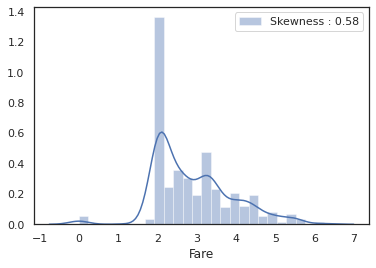

In [ ]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend()

### Categorical values

**Sex**

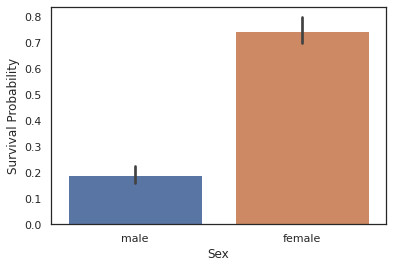

In [ ]:
g = sns.barplot(x="Sex", y="Survived", data=train)
g = g.set_ylabel("Survival Probability")

In [ ]:
train[["Sex", "Survived"]].groupby("Sex").mean()

,Survived
Sex,
female,0.747573
male,0.190893


It is clearly obvius that male have less chance to survive than Female.
So sex, might play an important role in the prediction of the survival.

**Pclass**

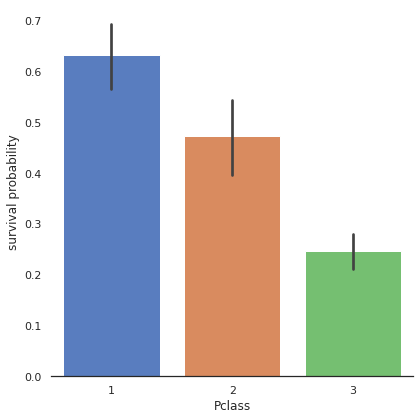

In [ ]:
g = sns.catplot(x="Pclass", y="Survived", data=train, kind="bar", height=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

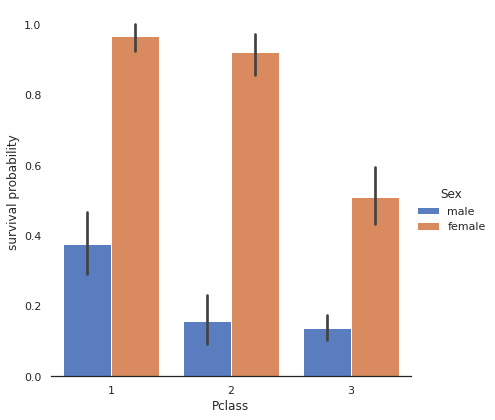

In [ ]:
# Explore Pclass vs Survived by Sex
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train, height=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

The passenger survival is not the same in the 3 classes. First class passengers have more chance to survive than second class and third class passengers.

This trend is conserved when we look at both male and female passengers.

**Embarked**

In [ ]:
dataset["Embarked"].isnull().sum()

2

In [ ]:
dataset["Embarked"].value_counts()

S    903
C    270
Q    123
Name: Embarked, dtype: int64

In [ ]:
dataset["Embarked"] = dataset["Embarked"].fillna("S")

Since we have two missing values, i decided to fill them with the most frequent value of "Embarked" (S).

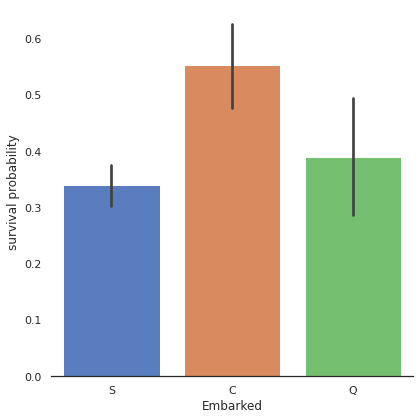

In [ ]:
# Explore Embarked vs Survived
g = sns.catplot(x="Embarked", y="Survived", data=train, height=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It seems that passenger coming from Cherbourg (C) have more chance to survive.

My hypothesis is that the proportion of first class passengers is higher for those who came from Cherbourg than Queenstown(Q), Southampton (S).

Let's see the Pclass distribution vs Embarked

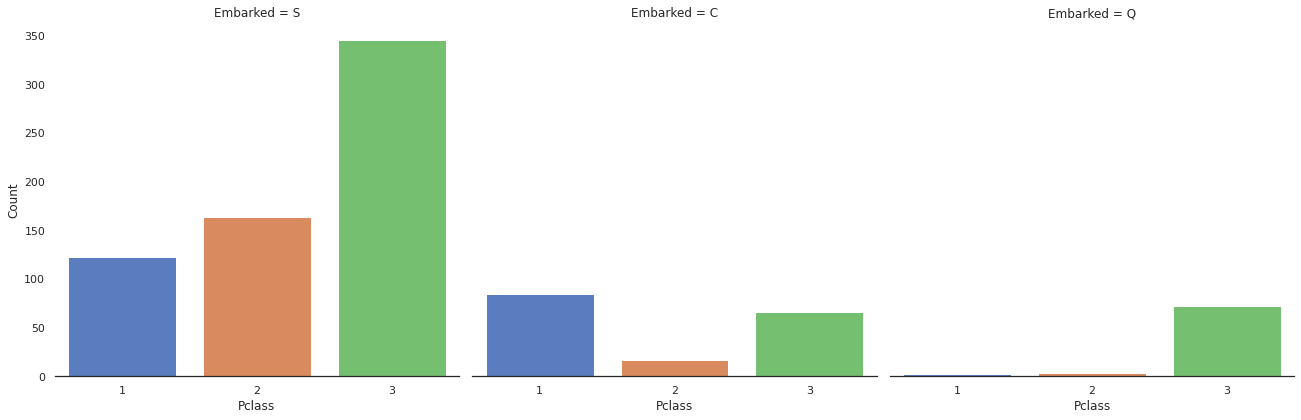

In [ ]:
# Explore Pclass vs Embarked
g = sns.catplot("Pclass", col="Embarked", data=train, height=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

Indeed, the third class is the most frequent for passenger coming from Southampton (S) and Queenstown (Q), whereas Cherbourg passengers are mostly in first class which have the highest survival rate.

At this point, i can't explain why first class has an higher survival rate. My hypothesis is that first class pasengers were prioritised during the evacuation due to their influence.

## Filling missing Values

### Age

As we see, Age column contain 256 missing values in the whole dataset.

Since there is subpopulations that have more chance to survive (children for example), it is preferable to keep the age feature and to impute the missing values.

To address this problem, i looked at the most correlated features with Age(Sex,Parch, Pclass, and SibSp)

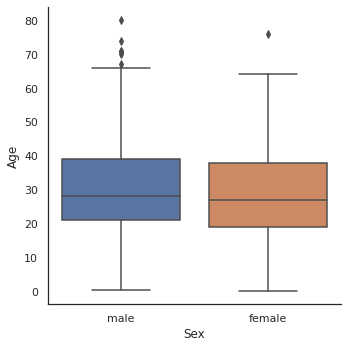

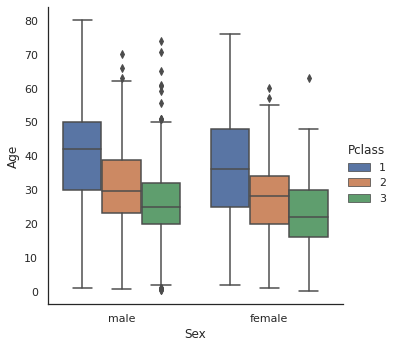

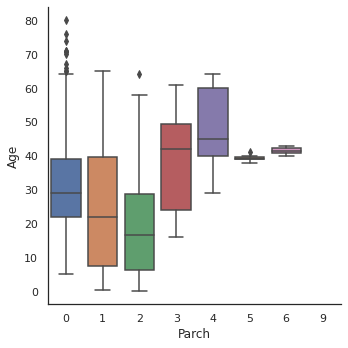

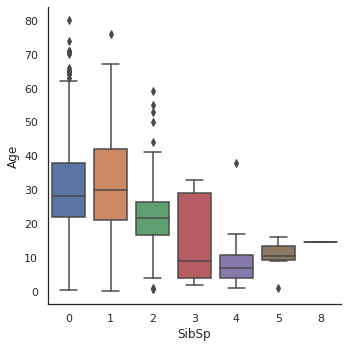

In [ ]:
# Explore Age vs Sex, Parch, Pclass and SibSp
g = sns.catplot(y="Age", x="Sex", data=dataset, kind="box")
g = sns.catplot(y="Age", x="Sex", hue="Pclass", data=dataset, kind="box")
g = sns.catplot(y="Age", x="Parch", data=dataset, kind="box")
g = sns.catplot(y="Age", x="SibSp", data=dataset, kind="box")

Age distribution seems to be the same in Male and Female subpopulations, so Sex is not informative to predict Age.

However, 1rst class passengers are older than 2nd class passengers who are also older than 3rd clas passengers.

Moreover, the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is.

In [ ]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male":0, "female":1})

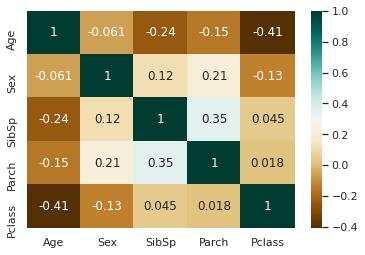

In [ ]:
g = sns.heatmap(dataset[["Age", "Sex", "SibSp", "Parch", "Pclass"]].corr(), cmap="BrBG", annot=True)

The correlation map confirms the factorplots observations except for Parch. Age is not correlated with Sex, but is negatively correlated with Pclass, Parch, and SibSp.

In the plot of Age in function of Parch, Age is growing with the number of parents/children. But the general correlation is negative.

So, i decided to use SibSp, Parch, and Pclass in order to impute the missing ages.

The strategy is to fill Age with the median age of similar rows according to Pclass, Parch and SibSp.

In [ ]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age:
  age_med = dataset["Age"].median()
  age_pred = dataset["Age"][((dataset["SibSp"]==dataset.iloc[i]["SibSp"]) & (dataset["Parch"]==dataset.iloc[i]["Parch"]) & (dataset["Pclass"]==dataset.iloc[i]["Pclass"]))].median()
  if not np.isnan(age_pred):
    dataset["Age"].iloc[i]=age_pred
  else:
    dataset["Age"].iloc[i]=age_med

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


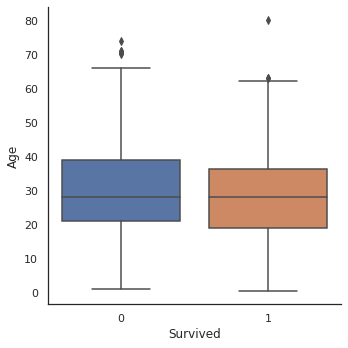

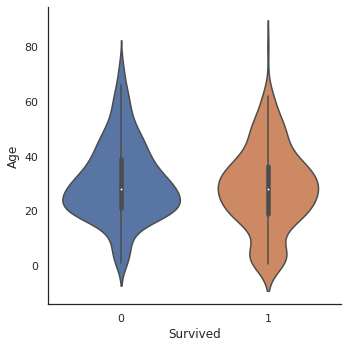

In [ ]:
g = sns.catplot(x="Survived", y="Age", data=train, kind="box")
g = sns.catplot(x="Survived", y="Age", data=train, kind="violin")

No difference between median value of age in survived and not survived subpopulation.

But in the violin plot of survived passengers, we still notice that very young passengers have higher survival rate.

## Feature engineering

### Name/Title

In [ ]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

The Name feature contains information on passenger's title

Since some passenger with distingused title may be preferred during the evacuation, it is interesting to add them to the model.

In [ ]:
# Get Title from Name
dataset_title=[i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

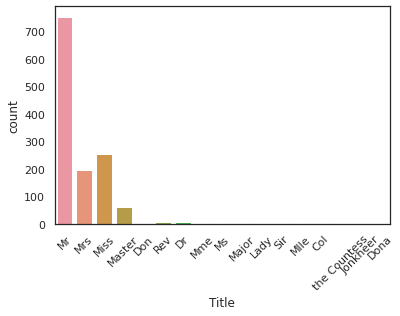

In [ ]:
g = sns.countplot(x="Title", data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

There is 17 titles in the dataset, most of them are very rare and we can group them in 4 categories.

In [ ]:
# Convert to categorical values Title
dataset["Title"] = dataset["Title"].replace(["Lady", "the Countess", "Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"], "Rare")
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms":1, "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

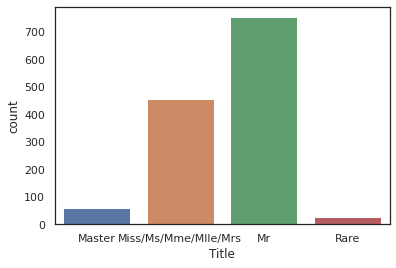

In [ ]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])

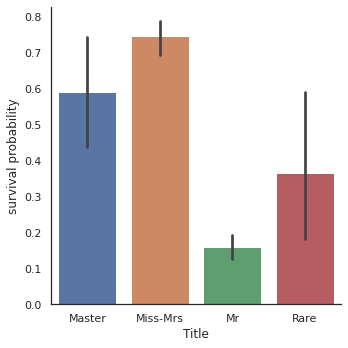

In [ ]:
g = sns.catplot(x="Title", y="Survived", data=dataset, kind="bar")
g = g.set_xticklabels(["Master", "Miss-Mrs", "Mr", "Rare"])
g = g.set_ylabels("survival probability")

It is interesting to note that passengers with rare title have more chance to survive than Mr.

In [ ]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis=1, inplace = True)

### Family size

We can imagine that large families will have more difficulties to evacuate, looking for theirs sisters/brothers/parents during the evacuation. Si, i choosed to create a "Fize"(family size) feature which is the sum of SibSp, Parch and 1(including the passenger).

In [ ]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"]+dataset["Parch"]+1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


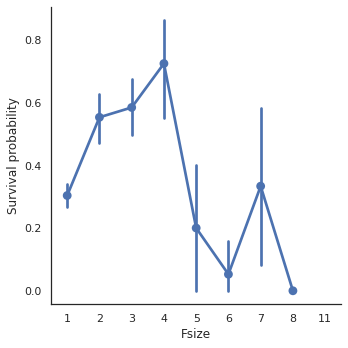

In [ ]:
g = sns.factorplot(x="Fsize", y="Survived", data=dataset)
g = g.set_ylabels("Survival probability")

The family size seems to play an important role, survival probability is worst for large families.

Additionally, i decided to created 4 categories of family size.

In [ ]:
# Create a new feature of family size
dataset["Single"] = dataset["Fsize"].map(lambda s: 1 if s==1 else 0)
dataset["SmallF"] = dataset["Fsize"].map(lambda s: 1 if s==2 else 0)
dataset["MedF"] = dataset["Fsize"].map(lambda s: 1 if 3 <= s <=4 else 0)
dataset["LargeF"] = dataset["Fsize"].map(lambda s: 1 if s>=5 else 0)

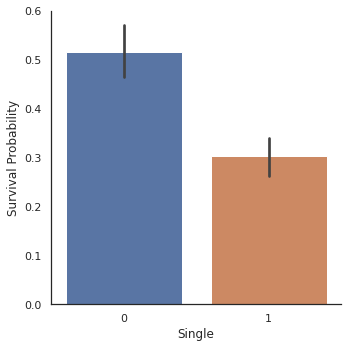

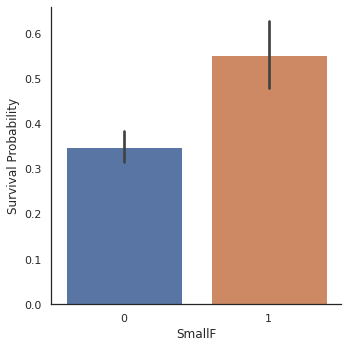

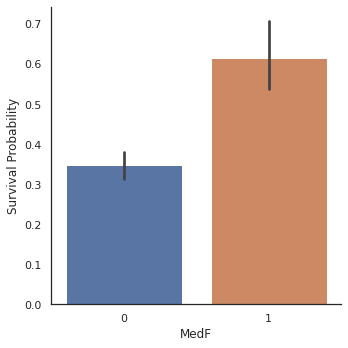

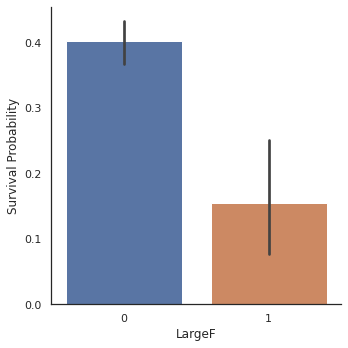

In [ ]:
g = sns.catplot(x="Single", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="SmallF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="MedF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="LargeF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

Catplots of family size categories show that Small and Medium families have more chance to survive than single passenger and large families.

In [ ]:
# convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns=["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix = "Em")

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,2,0,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,2,0,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,1,1,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,2,0,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,1,1,0,0,0,0,0,1,0,0,0,1


A this stage, we have 22 features.

### Cabin

In [ ]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [ ]:
dataset["Cabin"].describe()

count     291
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [ ]:
dataset["Cabin"].isnull().sum()

1007

The Cabin feature column contains 292 values and 1007 values.

I supposed that passengers without a cabin have a messing value displayed instead of the cabin number.

In [ ]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [ ]:
# Replace the Cabin number by the type of cabin "X", if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else "X" for i in dataset["Cabin"]])

The first letter of the cabin indicates the Desk, i choosed to keep this information only, since it indicate the probable location of the passenger in the Titanic.

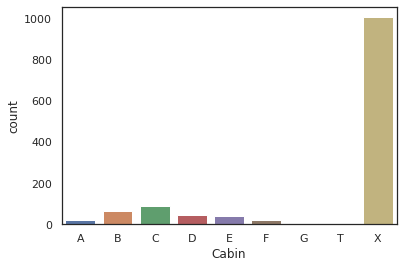

In [ ]:
g = sns.countplot(dataset["Cabin"], order = 
                  ["A","B","C","D","E","F","G","T","X"])

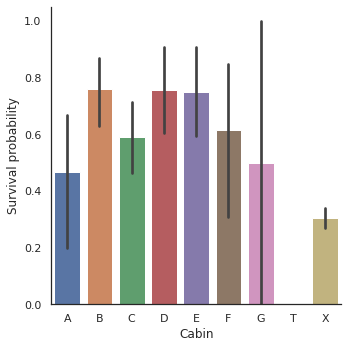

In [ ]:
g = sns.catplot(y="Survived", x="Cabin", data=dataset, kind="bar", order=
                ["A","B","C","D","E","F","G","T","X"])

g = g.set_ylabels("Survival probability")

Because of the low number of passenger that have a cabin, survival probabilities have an important standard deviation and we can't distinguish between survival probability of passengers in the different desks.

But we can see that passengers with a cabin have generally more chance to survive than passengers withouth(X).

It is particularly true for cabin B,C,D,E and F.

In [ ]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"], prefix="Cabin")

### Ticket

In [ ]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

It could mean that tickets sharing the same prefixes could be booked for cabins placed together.
It could therefore lea to the actual placement of the cabins within the ship.

Tickets with same prefixes may have similar class and survival.

So i decided to replace the ticket feature column bi the ticket prefix. Which may be more informative.

In [ ]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X.
Ticket = []
for i in list(dataset.Ticket):
  if not i.isdigit():
    Ticket.append(i.replace(".","").replace("/","").strip().split(" ")[0])
  else:
    Ticket.append("X")

dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [ ]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [ ]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns =["Pclass"], prefix="Pc")

In [ ]:
# Drop useless variables
dataset.drop(labels=["PassengerId"], axis=1, inplace=True)

In [ ]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,T_A,T_A4,T_A5,T_AQ3,T_AQ4,T_AS,T_C,T_CA,T_CASOTON,T_FC,T_FCC,T_Fa,T_LINE,T_LP,T_PC,T_PP,T_PPP,T_SC,T_SCA3,T_SCA4,T_SCAH,T_SCOW,T_SCPARIS,T_SCParis,T_SOC,T_SOP,T_SOPP,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


## Modeling

In [ ]:
## Separate train dataet and test dataset

train=dataset[:train_len]
test=dataset[train_len:]
test.drop(labels=["Survived"], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
## Separate train features and label
train["Survived"] = train["Survived"].astype(int)
Y_train = train["Survived"]
X_train = train.drop(labels=["Survived"], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Simple modeling

#### Cross validate models

I compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.

* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceptron (neural network)
* KNN
* Logistic Regression
* Linear Discriminant Analysis

In [ ]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

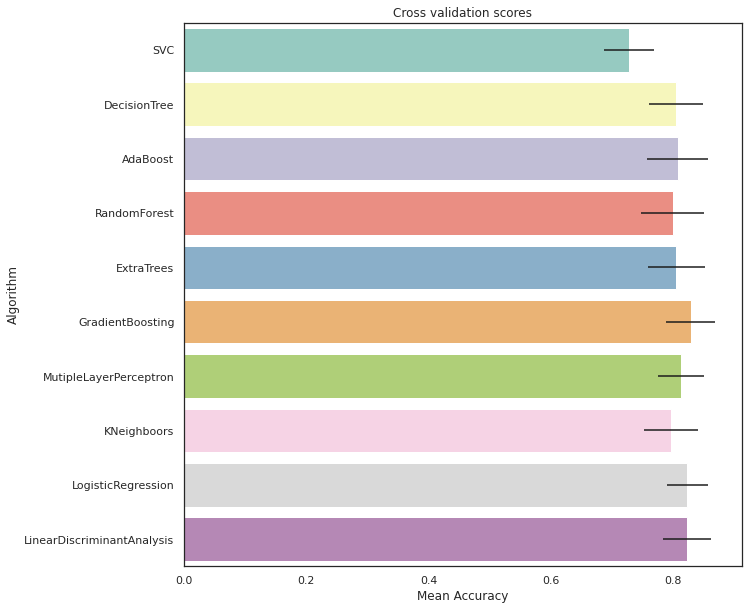

In [ ]:
# Modeling step Step different algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results=[]

for classifier in classifiers:
  cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring="accuracy", cv=kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
  cv_means.append(cv_result.mean())
  cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means, "CrossValErrors":cv_std, "Algorithm":["SVC", "DecisionTree", "AdaBoost", "RandomForest", "ExtraTrees", "GradientBoosting", "MutipleLayerPerceptron", "KNeighboors", "LogisticRegression", "LinearDiscriminantAnalysis"]})

plt.subplots(figsize=(10,10))
g = sns.barplot("CrossValMeans", "Algorithm", data=cv_res, palette="Set3", orient="h", **{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

I decided to choose the SVC, AdaBoost, RandomForest, ExtraTrees and the GradientBoosting classifier for the ensemble modeling.

#### Hyperparameter tunning for best models

I performed a grid search optimization for AdaBoost, ExtraTrees, RandomForest, GradientBOosting and SVC classifiers.

I set the "n_jobs" parameter to 4 since i have 4 cpu.

In [ ]:
## Meta modeling with adaboost, rf, extratrees and gradientboosting

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion":["gini", "entropy"],
                  "base_estimator__splitter": ["best", "random"],
                  "algorithm": ["SAMME", "SAMME.R"],
                  "n_estimators":[1,2],
                  "learning_rate":[0.0001,0.001,0.01,0.1,0.2,0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 728 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 1113 out of 1120 | elapsed:   12.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:   12.3s finished


In [ ]:
gsadaDTC.best_score_

0.8238636363636365

In [ ]:
#Extra trees
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {"max_depth":[None],
                 "max_features":[1,3,10],
                 "min_samples_split":[2,3,10],
                 "min_samples_leaf":[1,3,10],
                 "bootstrap":[False],
                 "n_estimators": [100,300],
                 "criterion":["gini"]}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   42.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.0min finished


0.8329545454545453

In [ ]:
# RFC Parameters tunning
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth":[None],
                 "max_features":[1,3,10],
                 "min_samples_split":[2,3,10],
                 "min_samples_leaf":[1,3,10],
                 "bootstrap":[False],
                 "n_estimators":[100,300],
                 "criterion":["gini"]}

gsRFC = GridSearchCV(RFC,param_grid=rf_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   43.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.2min finished


0.8340909090909092

In [ ]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()

gb_param_grid = {"loss":["deviance"],
                 "n_estimators":[100,200,300],
                 "learning_rate":[0.1,0.05,0.01],
                 "max_depth":[4,8],
                 "min_samples_leaf":[100,150],
                 "max_features":[0.3,0.1]}

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv = kfold, scoring = "accuracy", n_jobs = 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   53.7s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  1.4min finished


0.8375

In [ ]:
### SVC classifier

SVMC = SVC(probability=True)
svc_param_grid = {"kernel":["rbf"],
                  "gamma":[0.001,0.01,0.1,1],
                  "C":[1,10,50,100,200,300,1000]}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsSVMC.fit(X_train,Y_train)

SVMC_best=gsSVMC.best_estimator_

gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   45.5s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:  1.3min finished


0.8340909090909092

#### Plot learning curves

Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(0.1,1.0,5)):
  """
  Generate a simple plot of thtest and training learning curve
  """
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)

  plt.xlabel("Training examples")
  plt.ylabel("Score")
  train_sizes, train_scores, test_scores = learning_curve(
      estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()

  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
  plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training Score")
  plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
  plt.legend(loc="best")
  return plt

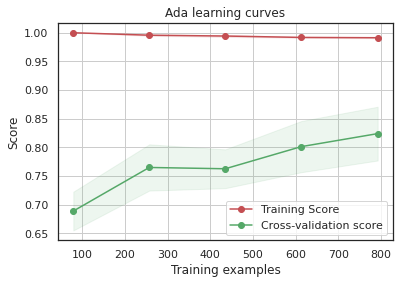

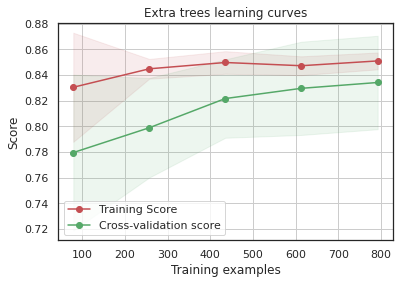

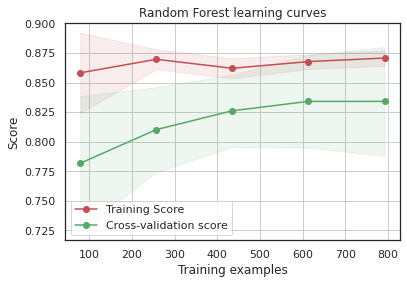

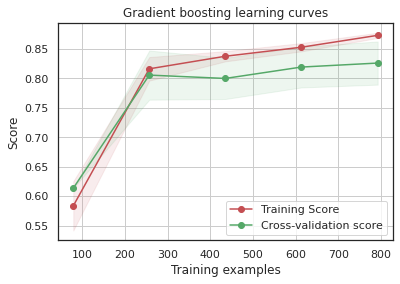

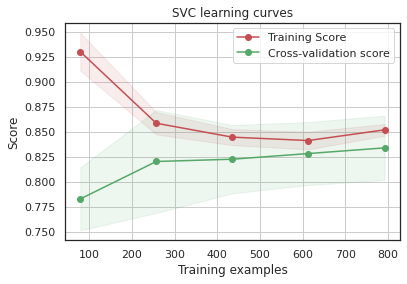

In [ ]:
g = plot_learning_curve(ada_best, "Ada learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(ExtC_best, "Extra trees learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(RFC_best, "Random Forest learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(GBC_best, "Gradient boosting learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(SVMC_best, "SVC learning curves", X_train, Y_train, cv=kfold)

GradientBoosting and Adaboost classifiers tend to overfit the training set. According to the growing cross-validation curves GradientBoosting and Adaboost could perform better with more training examples.

SVC and ExtraTrees classifiers seem to better generalize the prediction since the training and cross-validation curves are close together.



#### Feature importance of tree based classifiers

In order to see the most informative features for the predictions of passengers survival, i displayed the feature importance fo rthe 4 tree based classifiers.

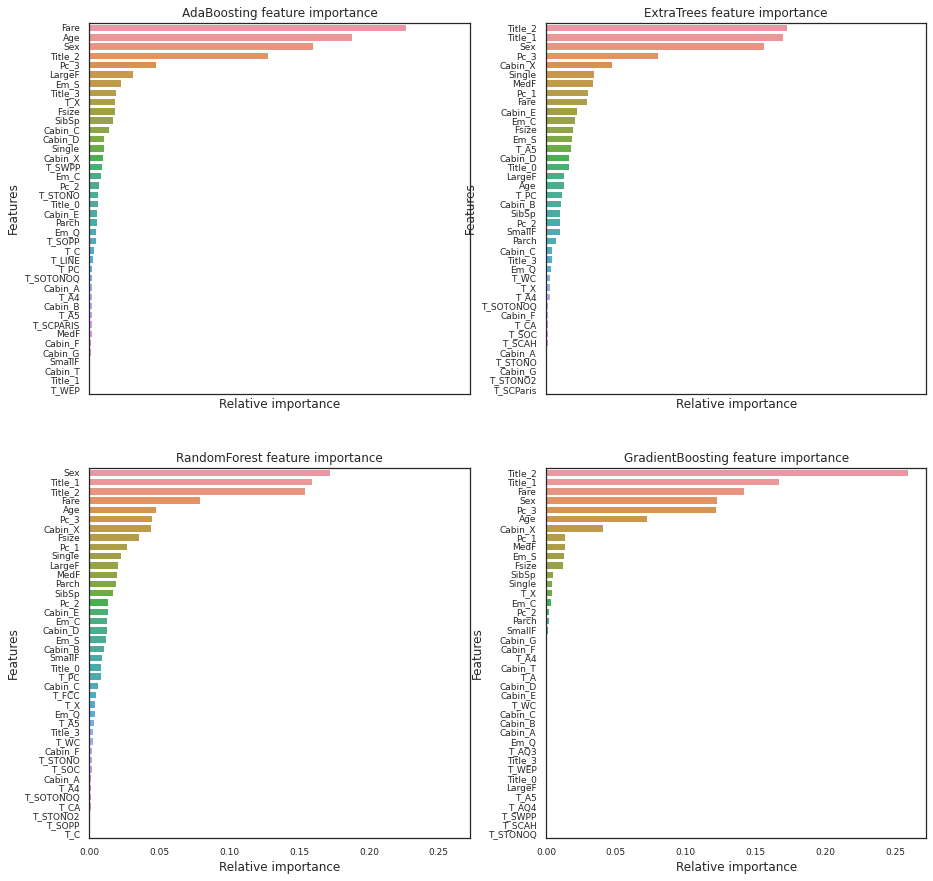

In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex="all", figsize=(15,15))
names_classifiers = [("AdaBoosting", ada_best), ("ExtraTrees", ExtC_best), ("RandomForest", RFC_best), ("GradientBoosting", GBC_best)]

nclassifier = 0
for row in range(nrows):
  for col in range(ncols):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40], orient="h", ax=axes[row][col])
    g.set_xlabel("Relative importance", fontsize=12)
    g.set_ylabel("Features", fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + " feature importance")
    nclassifier +=1

I plot the feature importance for the 4 tree baed classifiers (Adaboost,ExtraTrees, RandomForest and GradientBoosting).

We note that the four classifiers have different top features according to the relative importance, It means that their predictions are not based on the same features. Nevertheless, they share some common importante features for the classification, for example "Fare", "Title_2", "Age", and "Sex".

Title_2 which indicates the Mrs/Mlle/Mme/Miss/Ms category is highly correlated with Sex.

We can say that:
* Pc_1, Pc_2, Pc_3 and Fare refer to the general social standing of passengers.
* Sex and Title_2 and Title_3 refer to the gender.
* Age and Title_1 refer to the age of passengers.
* Fsize, LargeF, MedF, Single refer to the size of the passenger family.

**According to the feature importance of this 4 classifiers, the prediction of the survival seems to be more associated with the Age, the Sex, the family size and the social standing of the passengers more than the location in the boat.**

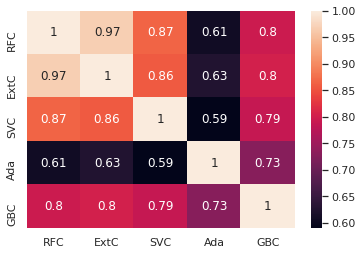

In [ ]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

# Concatenate all classifier results

ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_SVMC, test_Survived_AdaC, test_Survived_GBC], axis=1)

g = sns.heatmap(ensemble_results.corr(),annot=True)


The predictions seems to be quite similar for the 5 classifiers except when Adaboost is compared to the other classifiers.

The 5 classifiers give more or less the same prediction but there is some differences. These differences between the 5 classifier predictions are sufficient to consider an ensembling vote.

### Ensemble modeling

#### Combining models

I choosed a voting classifier to combine the predictions coming from the 5 classifiers.

I preferred to pass the argument "soft" to the voting parameter to take into account the probability of each vote

In [ ]:
votingC = VotingClassifier(estimators=[("rfc", RFC_best), ("extc", ExtC_best), ("svc", SVMC_best), ("adac", ada_best), ("gbc", GBC_best)], voting = "soft", n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [ ]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest, test_Survived], axis=1)

results.to_csv("ensemble_python_titanic.csv", index=False)